=== Driving Statistics at Legal-Limit (4-drink) Safety Threshold ===

1 seizure / week (baseline seizure prob = 0.1331)
-------------------------------------------------------
AUC = 0.60: Cannot reach legal-limit safety threshold

AUC = 0.90: FPR = 0.979, Sensitivity = 1.000
   Days in warning per year: 358.3
   Days allowed to drive per year: 6.7
   Average interval between driving days: 54.7 days

AUC = 0.95: FPR = 0.839, Sensitivity = 1.000
   Days in warning per year: 314.1
   Days allowed to drive per year: 50.9
   Average interval between driving days: 7.2 days


1 seizure / month (baseline seizure prob = 0.0328)
-------------------------------------------------------
AUC = 0.60: Cannot reach legal-limit safety threshold

AUC = 0.90: FPR = 0.867, Sensitivity = 0.998
   Days in warning per year: 317.9
   Days allowed to drive per year: 47.1
   Average interval between driving days: 7.8 days

AUC = 0.95: FPR = 0.591, Sensitivity = 0.995
   Days in warning per year: 220.6
   Days al

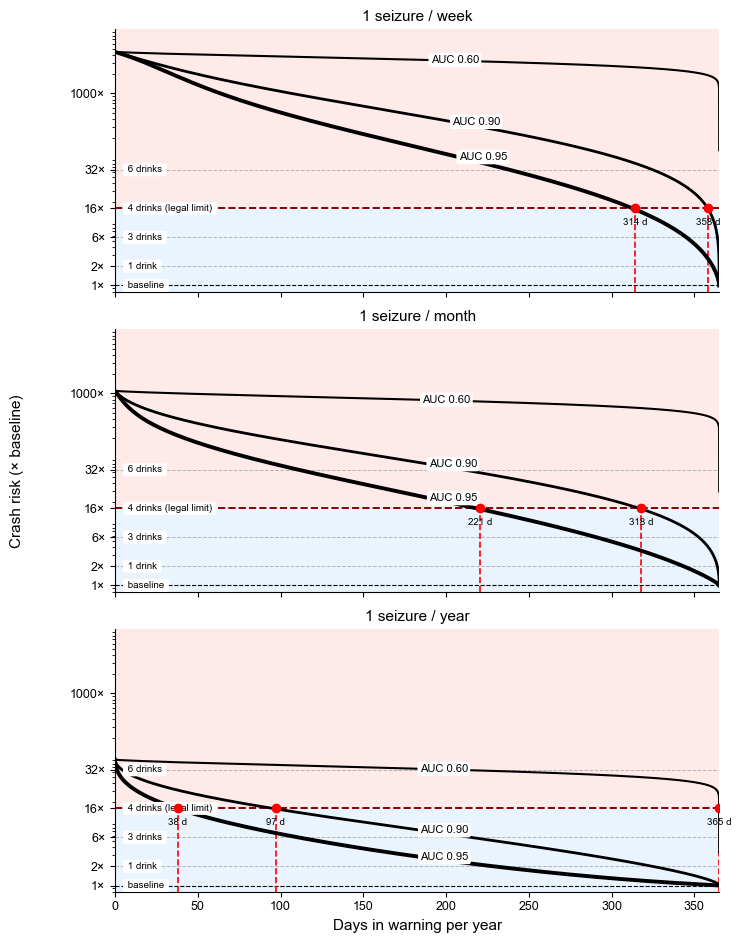

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# -------------------------------------------------
# Global style (good for journals like JAMA Neurol)
# -------------------------------------------------
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 9,
})

# -------------------------
# Configuration
# -------------------------
R = [1/7, 1/30, 1/365]
R_labels = ['1 seizure / week', '1 seizure / month', '1 seizure / year']

# Focus on the three most informative AUROCs
auc_values = [0.60, 0.90, 0.95]
auc_linewidth = {0.60: 1.5, 0.90: 2.0, 0.95: 2.8}

# Reference crash risks (baseline sober risk p0)
p0 = 1.5e-5
p1 = p0 * 2**(0.02/0.02)   # 1 drink
p3 = p0 * 2**(0.05/0.02)   # 3 drinks
p4 = p0 * 2**(0.08/0.02)   # 4 drinks (legal limit)
p6 = p0 * 2**(0.12/0.02)   # 6 drinks

y_limits = [0.8, 1e4]
p_crash_seizure = 0.5  # P(crash | seizure while driving)

# -------------------------
# Helper
# -------------------------
def compute_curve_for_auc(auc, p_seizure):
    """Return days_warning, pc_relative, sensitivity, FPR for given AUC and daily seizure prob."""
    m = np.sqrt(2) * norm.ppf(auc)
    th = np.linspace(-10, 10, 1000)

    s_ana = norm.cdf(m - th)      # sensitivity
    f_ana = 1 - norm.cdf(th)      # FPR

    num = norm.cdf(th - m) * p_seizure
    den = num + norm.cdf(th) * (1 - p_seizure)
    pn_ana = num / den            # P(seizure | "safe" day)

    p_warning = s_ana * p_seizure + f_ana * (1 - p_seizure)
    days_warning = p_warning * 365

    pc_ana = pn_ana * p_crash_seizure + (1 - pn_ana) * p0
    pc_relative = pc_ana / p0

    return days_warning, pc_relative, s_ana, f_ana

# -------------------------
# Figure 1: crash risk vs warning days
# -------------------------
fig, axes = plt.subplots(3, 1, figsize=(7.5, 9.5), sharex=True)

print('=== Driving Statistics at Legal-Limit (4-drink) Safety Threshold ===\n')

for j, (r, ax) in enumerate(zip(R, axes)):
    # Baseline daily seizure probability (Poisson process)
    p = 1 - np.exp(-r)
    print(f'{R_labels[j]} (baseline seizure prob = {p:.4f})')
    print('-' * 55)

    # Light-pink shaded "unsafe" region above legal limit
    ax.axhspan(p4/p0, y_limits[1],
               facecolor='#ffcccc', alpha=0.4, zorder=0)
    
    # Light-blue shaded "safe" region below legal limit
    ax.axhspan(y_limits[0], p4/p0,
               facecolor='#cce5ff', alpha=0.4, zorder=0)

    # Horizontal reference lines
    ax.axhline(y=1,       color='k',        linestyle='--', linewidth=0.8, zorder=1)
    ax.axhline(y=p1/p0,   color='0.7',      linestyle='--', linewidth=0.7, zorder=1)
    ax.axhline(y=p3/p0,   color='0.7',      linestyle='--', linewidth=0.7, zorder=1)
    ax.axhline(y=p4/p0,   color='darkred',  linestyle='--', linewidth=1.4, zorder=2)
    ax.axhline(y=p6/p0,   color='0.7',      linestyle='--', linewidth=0.7, zorder=1)

    # Curves for each AUC
    for auc in auc_values:
        days_warning, pc_rel, s_ana, f_ana = compute_curve_for_auc(auc, p)

        ax.plot(days_warning, pc_rel,
                color='k', linewidth=auc_linewidth[auc], zorder=3)

        # Sort for cross detection
        idx_sort = np.argsort(days_warning)
        dw_sorted = days_warning[idx_sort]
        pc_sorted = pc_rel[idx_sort]
        s_sorted = s_ana[idx_sort]
        f_sorted = f_ana[idx_sort]

        # First point where crash risk drops below legal-limit threshold
        idx_cross = np.where(pc_sorted < p4/p0)[0]
        if len(idx_cross) > 0:
            idx_cross = idx_cross[0]
            dw_cross = dw_sorted[idx_cross]
            s_cross = s_sorted[idx_cross]
            f_cross = f_sorted[idx_cross]

            # Vertical red dashed line + red marker
            ax.plot([dw_cross, dw_cross],
                    [y_limits[0], p4/p0],
                    'r--', linewidth=1.2, zorder=2)
            ax.plot(dw_cross, p4/p0,
                    'o', color='red', markersize=6, zorder=4)

            # Label with number of warning days
            ax.text(dw_cross, p4/p0*0.7,
                    f'{dw_cross:.0f} d',
                    fontsize=7, ha='center', va='top')

            # Text output for table / checking
            p_warning_cross = s_cross * p + f_cross * (1 - p)
            p_safe = 1 - p_warning_cross
            days_driving = p_safe * 365
            avg_interval = 1 / p_safe

            print(f'AUC = {auc:.2f}: FPR = {f_cross:.3f}, Sensitivity = {s_cross:.3f}')
            print(f'   Days in warning per year: {dw_cross:.1f}')
            print(f'   Days allowed to drive per year: {days_driving:.1f}')
            print(f'   Average interval between driving days: {avg_interval:.1f} days\n')
        else:
            print(f'AUC = {auc:.2f}: Cannot reach legal-limit safety threshold\n')

        # Label the curve around its median x
        mid_idx = np.argmin(np.abs(days_warning - np.median(days_warning)))
        ax.text(days_warning[mid_idx], pc_rel[mid_idx],
                f'AUC {auc:.2f}',
                fontsize=8, ha='left', va='center',
                bbox=dict(boxstyle='round,pad=0.2',
                          facecolor='white', edgecolor='none'))

    # Panel formatting
    ax.set_ylim(y_limits)
    ax.set_xlim([0, 365])
    ax.set_yscale('log')
    ax.set_title(R_labels[j], fontsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Drink labels
    ax.text(6, 1,        ' baseline ',               fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'))
    ax.text(6, p1/p0,    ' 1 drink ',                fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'))
    ax.text(6, p3/p0,    ' 3 drinks ',               fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'))
    ax.text(6, p4/p0,    ' 4 drinks (legal limit) ', fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'))
    ax.text(6, p6/p0,    ' 6 drinks ',               fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'))

    # Intuitive y-ticks
    ax.set_yticks([1, p1/p0, p3/p0, p4/p0, p6/p0, 1e3])
    ax.set_yticklabels(['1×', '2×', '6×', '16×', '32×', '1000×'])

    print()

# Shared labels
fig.text(0.02, 0.5, 'Crash risk (× baseline)', va='center',
         rotation='vertical', fontsize=11)
axes[-1].set_xlabel('Days in warning per year', fontsize=11)

plt.tight_layout()
plt.subplots_adjust(left=0.16)

fig.savefig('Figure_1.pdf',
            facecolor='white', bbox_inches='tight')

plt.show()

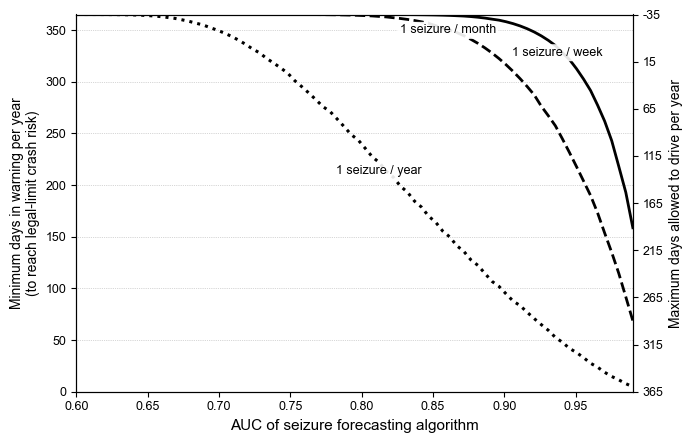

In [23]:
# -------------------------------------------------
# Figure 2: minimum warning days vs AUC (inline labels on curves)
# -------------------------------------------------

auc_grid = np.linspace(0.60, 0.99, 80)

min_warning_days = {label: [] for label in R_labels}

for r, label in zip(R, R_labels):
    p = 1 - np.exp(-r)
    for auc in auc_grid:
        dw, pc_rel, s_ana, f_ana = compute_curve_for_auc(auc, p)

        idx_sort = np.argsort(dw)
        dw_sorted = dw[idx_sort]
        pc_sorted = pc_rel[idx_sort]

        idx_cross = np.where(pc_sorted < p4/p0)[0]
        if len(idx_cross) > 0:
            min_dw = dw_sorted[idx_cross[0]]
        else:
            min_dw = np.nan
        min_warning_days[label].append(min_dw)

# Convert to arrays
for k in min_warning_days:
    min_warning_days[k] = np.array(min_warning_days[k])

fig2, ax2 = plt.subplots(figsize=(7, 4.5))

styles = {
    '1 seizure / week':  ('-',  2.0),
    '1 seizure / month': ('--', 2.0),
    '1 seizure / year':  (':',  2.2),
}

# Plot the three curves
for label in R_labels:
    ls, lw = styles[label]
    ax2.plot(auc_grid, min_warning_days[label],
             linestyle=ls, linewidth=lw, color='k')

ax2.set_xlim(0.60, 0.99)
ax2.set_ylim(0, 365)
ax2.set_xlabel('AUC of seizure forecasting algorithm', fontsize=11)
ax2.set_ylabel('Minimum days in warning per year\n(to reach legal-limit crash risk)', fontsize=10)

# Shared tick locations for both y-axes
ticks = np.arange(0, 401, 50)
ax2.set_yticks(ticks)
ax2.set_ylim(0, 365)

ax2b = ax2.twinx()
ax2b.set_ylim(0, 365)
ax2b.set_yticks(ticks)
ax2b.set_yticklabels([f'{int(365 - v)}' for v in ticks])
ax2b.set_ylabel('Maximum days allowed to drive per year', fontsize=10)

ax2.grid(axis='y', linestyle=':', linewidth=0.5)

# -------- inline labels ON the curves, inside the plot --------
# choose positions ~50–70% along the reachable AUC range, so they sit nicely inside
label_frac = {
    '1 seizure / week': 0.85,
    '1 seizure / month': 0.65,
    '1 seizure / year': 0.55,
}

for label in R_labels:
    y_vals = min_warning_days[label]
    valid_idx = np.where(~np.isnan(y_vals))[0]
    if len(valid_idx) == 0:
        continue

    frac = label_frac[label]
    i = valid_idx[int(frac * len(valid_idx))]
    x = auc_grid[i]-.035
    y = y_vals[i]

    ax2.text(
        x, y,
        label,
        fontsize=9,
        va='center',
        ha='left',
        bbox=dict(
            boxstyle='round,pad=0.2',
            facecolor='white',
            edgecolor='none',
            alpha=0.9
        )
    )

fig2.tight_layout()
fig2.savefig('Figure_S1.pdf',
             facecolor='white', bbox_inches='tight')
plt.show()


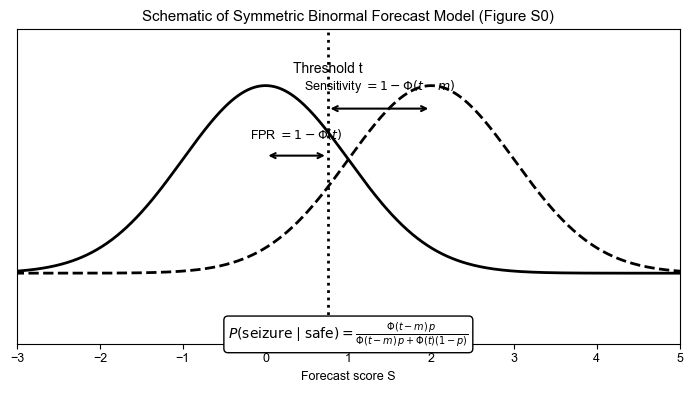

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for schematic
m = 2.0        # example separation (AUC ≈ 0.92)
t = 0.75       # threshold for illustration
x = np.linspace(-4, 6, 500)

# Distributions
y_non = norm.pdf(x, 0, 1)
y_seiz = norm.pdf(x, m, 1)

fig, ax = plt.subplots(figsize=(7, 4))

# Plot the two Gaussians
ax.plot(x, y_non, color='black', linewidth=2, label='Non-seizure (N(0,1))')
ax.plot(x, y_seiz, color='black', linestyle='--', linewidth=2, label='Seizure (N(m,1))')

# Threshold line
ax.axvline(t, color='black', linestyle=':', linewidth=2)
ax.text(t, max(y_seiz)*1.05, 'Threshold t', ha='center', va='bottom', fontsize=10)

# Sensitivity arrow
ax.annotate(
    '', xy=(t, 0.35), xytext=(m, 0.35),
    arrowprops=dict(arrowstyle='<->', linewidth=1.5)
)
ax.text((t+m)/2, 0.38, r"Sensitivity $=1-\Phi(t-m)$", ha='center', va='bottom', fontsize=9)

# FPR arrow
ax.annotate(
    '', xy=(t, 0.25), xytext=(0, 0.25),
    arrowprops=dict(arrowstyle='<->', linewidth=1.5)
)
ax.text((t+0)/2, 0.28, r"FPR $=1-\Phi(t)$", ha='center', va='bottom', fontsize=9)

# Bayes box under curves
bayes_text = (
    r"$P(\text{seizure} \mid \text{safe}) = "
    r"\frac{\Phi(t-m)\, p}{\Phi(t-m)\, p + \Phi(t)(1-p)}$"
)

ax.text(
    1.0, -0.10, bayes_text,
    ha='center', va='top', fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
    transform=ax.transData
)

# Clean formatting
ax.set_ylim(-0.15, max(y_seiz)*1.3)
ax.set_xlim(-3, 5)
ax.set_yticks([])
ax.set_xlabel("Forecast score S")
ax.set_title("Schematic of Symmetric Binormal Forecast Model (Figure S0)")

plt.tight_layout()

# Save all formats
fig.savefig("Figure_S0.pdf", bbox_inches='tight')

plt.show()
